<a href="https://colab.research.google.com/github/437-maral/Deap-Learning-/blob/main/simple_diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import math
import matplotlib.pyplot as plt
import torch
import urllib
import numpy as np
import PIL

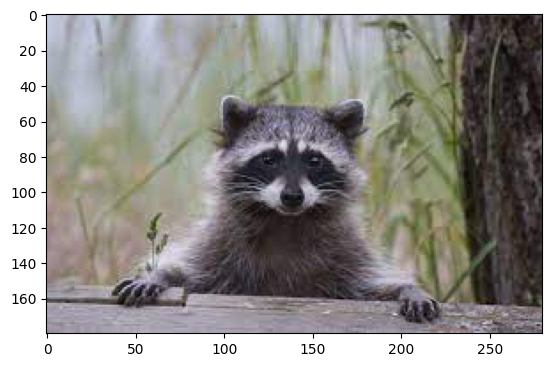

In [12]:
def get_sample_image()-> PIL.Image.Image:
    url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmJy3aSZ1Ix573d2MlJXQowLCLQyIUsPdniOJ7rBsgG4XJb04g9ZFA9MhxYvckeKkVmo&usqp=CAU'
    filename = 'racoon.jpg'
    urllib.request.urlretrieve(url, filename)
    return PIL.Image.open(filename)


image=get_sample_image()
plt.imshow(image)

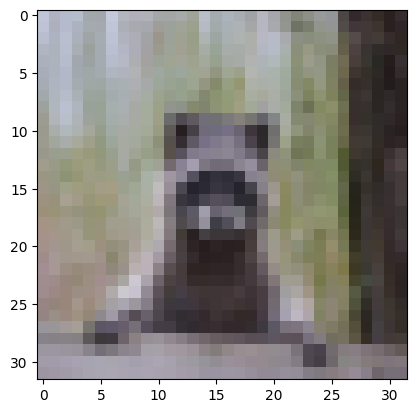

In [13]:
transform= transforms.Compose([
    transforms.Resize((32,32)), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])
reverse_transform= transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])

blur_image=transform(image)
plt.imshow(reverse_transform(blur_image))

In [14]:

###for froward diffusion
#defult calculation 
#beta_start=0.0001
#beta_end=0.02
#beta=torch.linspace(beta_start, beta_end, t)
#alpha=1-beta
#alpha_product=torch.cumprod(alpha, axis=0)


###for froward diffusion


def diffusion_forward(clean_image,timesteps,beta=torch.linspace(0.0,1.0,5)):
  noise=torch.randn_like(clean_image)
  alpha=1-beta
  alpha_product=torch.cumprod(alpha, axis=0)
  alpha_product_T=alpha_product[timesteps][:,None,None,None]
  alpha_squared=alpha_product_T.sqrt()
  one_minus_alpha_squared=1-alpha_product_T.sqrt()
  mean=alpha_squared*clean_image
  variance=one_minus_alpha_squared* noise

  return mean+variance , noise




In [15]:
t=torch.tensor([0,1,2,3,4])
###it needs to be batch size  in there 
batch_image=torch.stack([blur_image]*5)
noisy_image,_=diffusion_forward(batch_image,t)
noisy_image

tensor([[[[ 5.0588e-01,  3.8039e-01,  4.1961e-01,  ..., -5.8431e-01,
           -6.6275e-01, -5.6863e-01],
          [ 4.9020e-01,  3.6471e-01,  4.1961e-01,  ..., -5.1373e-01,
           -6.6275e-01, -6.0784e-01],
          [ 4.5098e-01,  3.7255e-01,  4.5882e-01,  ..., -4.7451e-01,
           -5.7647e-01, -6.1569e-01],
          ...,
          [ 2.2353e-01,  2.1569e-01,  2.0784e-01,  ..., -6.6667e-02,
           -1.5294e-01, -2.2353e-01],
          [ 2.7059e-01,  2.7059e-01,  2.9412e-01,  ...,  1.1765e-02,
           -3.9216e-03,  1.1765e-02],
          [ 2.3137e-01,  2.5490e-01,  2.6275e-01,  ..., -1.2941e-01,
           -6.6667e-02, -6.6667e-02]],

         [[ 5.4510e-01,  3.9608e-01,  4.5882e-01,  ..., -6.5490e-01,
           -7.4118e-01, -6.5490e-01],
          [ 5.2941e-01,  3.8039e-01,  4.5882e-01,  ..., -5.8431e-01,
           -7.4118e-01, -6.9412e-01],
          [ 4.9020e-01,  3.9608e-01,  4.9804e-01,  ..., -5.2941e-01,
           -6.4706e-01, -6.8627e-01],
          ...,
     

In [16]:
transform= transforms.Compose([
    transforms.Resize((32,32)), # Resize the input image
    transforms.ToTensor(), # Convert to torch tensor (scales data into [0,1])
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale data between [-1, 1] 
])
reverse_transform= transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2), # Scale data between [0,1]
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.Lambda(lambda t: t * 255.), # Scale data between [0.,255.]
    transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)), # Convert into an uint8 numpy array
    transforms.ToPILImage(), # Convert to PIL image
])
        

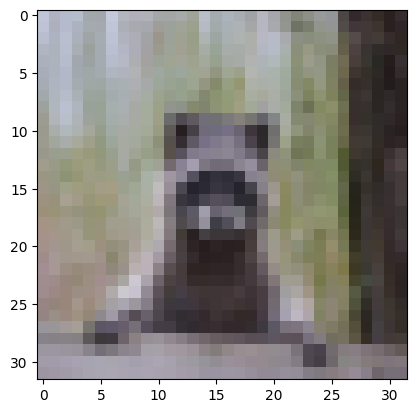

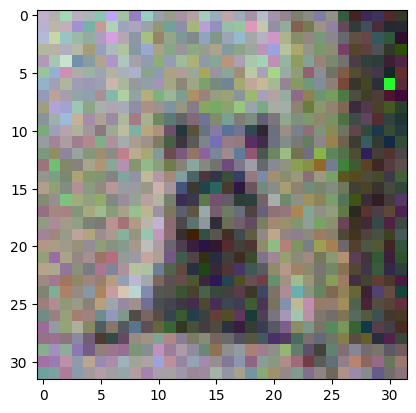

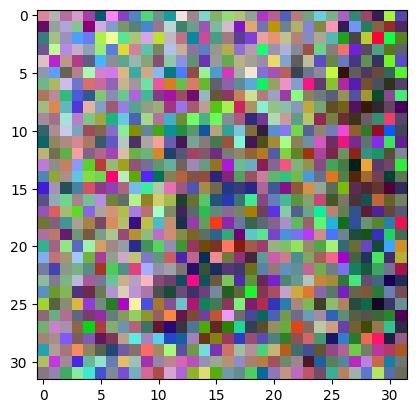

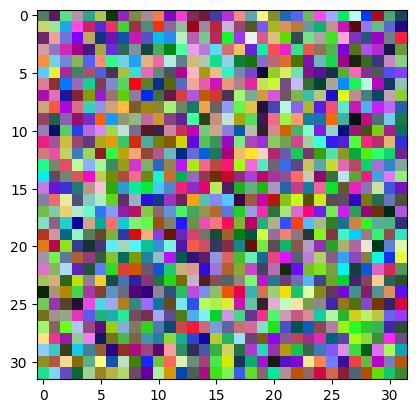

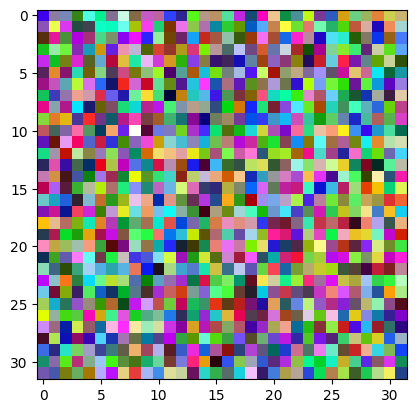

In [17]:
for new_image in noisy_image:
  plt.imshow(reverse_transform(new_image))
  plt.show()

In [7]:
!pip install diffusers


from diffusers import UNet2DModel
from dataclasses import dataclass
from tqdm.auto import tqdm
from PIL import Image
import torch
import torchvision


@dataclass
class TrainingConfig:
    image_size = 28  # the generated image resolution
    num_channels = 1  # the number of channels in the generated image
    train_batch_size = 5
    eval_batch_size = 2  # how many images to sample during evaluation
    num_epochs = 10
    learning_rate = 1e-4
    output_dir = "samples"

config = TrainingConfig()

num_train_timesteps=1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#####
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",  # a regular ResNet downsampling block
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "UpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
#let's do reverse function

def backward_diffusion(model,noise,timestep,beta=torch.linspace(0.0,1.0,5)):
  noise=torch.randn_like(clean_image)
  alpha=1-beta
  alpha_product=torch.cumprod(alpha, axis=0)
  alpha_product_T=alpha_product[timesteps][:,None,None,None]
  alpha_squared=alpha_product_T.sqrt()
  one_minus_alpha_squared=1-alpha_product_T.sqrt()

  #in backward,we work with xt
  noisy_images_list = []
  current_image = noise.to(device)
    
    # Perform reverse diffusion for the specified number of timesteps
  progress_bar = tqdm(range(timestep - 1))
    #for t in range(num_timesteps - 1, -1, -1):
  for t in range(1, timestep - 1)[::-1]:
        # Generate the noise for the current timestep
        progress_bar.set_description(f"T {t}")
        timesteps = torch.ones([current_image.shape[0]], dtype=torch.int32).to(device) * t
        current_noise = model(current_image, timesteps, return_dict=False)[0]

        # sigma = torch.tensor(0).to(device)
        sigma = torch.tensor(0.01 * (t / timestep)) if t > 1 else torch.tensor(0).to(device)
        z = torch.randn_like(current_image).to(device)

        #
        current_image = 1 / alpha * (current_image - (1 - alpha_product_T) /  one_minus_alpha_squared * current_noise) + sigma * z
        current_image = current_image.detach()
        if t % (num_timesteps / 10) == 0:
            noisy_images_list.append(current_image)
  return current_imag